In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pylab import text
import csv
from PIL import Image
from skimage.transform import resize
import pandas as pd
import os
from sklearn.utils import shuffle

In [2]:
DATA_PATH = '/datasets/home/21/321/ee228sp20ta1/G36/'

def load_rgb_data(file):
    # Opening 'pickle' file and getting images
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3
        x = d['features'].astype(np.float32)   # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        y = d['labels']                        # 1D numpy.ndarray type, for train = (34799,)
        s = d['sizes']                         # 2D numpy.ndarray type, for train = (34799, 2)
        c = d['coords']                        # 2D numpy.ndarray type, for train = (34799, 4)
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """

    # Returning ready data
    return x, y, s, c

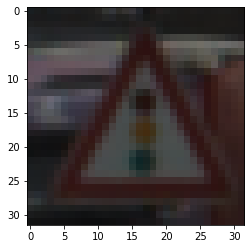

In [3]:
# Get training, validataion and test data

x_train, y_train, s_train, c_train = load_rgb_data(os.path.join(DATA_PATH, 'train.pickle'))
x_val, y_val, s__val, c_val = load_rgb_data(os.path.join(DATA_PATH, 'valid.pickle'))
x_test, y_test, s_test, c_test = load_rgb_data(os.path.join(DATA_PATH, 'test.pickle'))


# show images
img = x_train[np.random.randint(1,10000)]
plt.imshow(img.astype(np.uint8)) # show the corresponding rgb image using pyplot.
plt.show()

In [4]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [5]:
# Get All Labels
df = pd.read_csv(DATA_PATH+'label_names.csv')
label_list = df['SignName'].to_list()
label_list

['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'Right-of-way at the next intersection',
 'Priority road',
 'Yield',
 'Stop',
 'No vehicles',
 'Vehicles over 3.5 metric tons prohibited',
 'No entry',
 'General caution',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'Bumpy road',
 'Slippery road',
 'Road narrows on the right',
 'Road work',
 'Traffic signals',
 'Pedestrians',
 'Children crossing',
 'Bicycles crossing',
 'Beware of ice/snow',
 'Wild animals crossing',
 'End of all speed and passing limits',
 'Turn right ahead',
 'Turn left ahead',
 'Ahead only',
 'Go straight or right',
 'Go straight or left',
 'Keep right',
 'Keep left',
 'Roundabout mandatory',
 'End of no passing',
 'End of no passing 

In [6]:
def plot_unique_examples(images,labels,df):
    '''
    Plots the unique 
    images per label
    for given images
    and labels.
    
    Parameters
    ----------
    images : numpy ndarray
        Images to be selected
        from
        
    labels : numpy ndarray
        Respective labels
        of the images
        
    df : pandas dataframe
        Mapping of labels
        indices and their
        names.
        
    '''
    assert(isinstance(images,np.ndarray))
    assert(isinstance(labels,np.ndarray))
    assert(isinstance(df,pd.DataFrame))
    
    f, axarr = plt.subplots(11,4,figsize=(20,20))
    for i in range(4):
        for j in range(11):
            if((i+1)*(j+1)>=42):
                break
            idx = np.where(labels==11*i+j)
            axarr[j][i].imshow(images[idx][0].astype(np.uint8))
            axarr[j][i].set(ylabel = df.loc[11*i+j].SignName)

    plt.show()

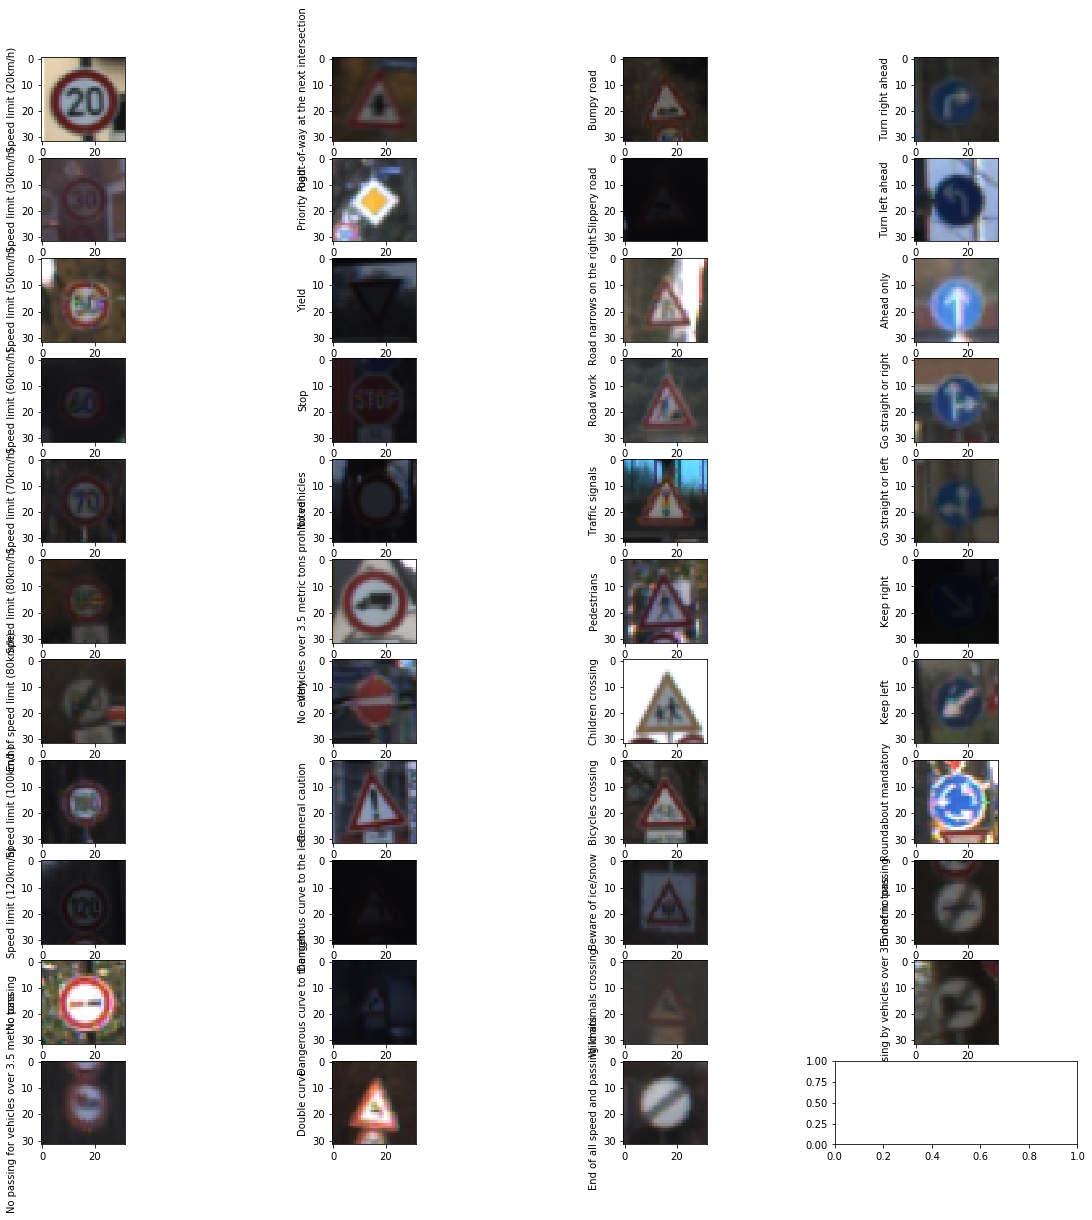

In [7]:
plot_unique_examples(x_train,y_train,df)

In [8]:
# Defining function for changing rotation of image
def rotate_image(img):
    '''
    Given an image,
    rotates it about
    its center.
    
    Parameters
    ----------
    img : numpy ndarray
    
    Source-
    ------
    https://www.tutorialkart.com/opencv/python/opencv-python-rotate-image/

    '''
    assert(isinstance(img,np.ndarray))
    
    angle_range = 30
    angle = np.random.uniform(angle_range) - angle_range/2
    rows, cols, chanls = img.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2 , rows/2),angle,1)
    rotated_img = cv2.warpAffine(img,rotation_matrix,(cols,rows))
    
    return rotated_img

def change_brightness(img):
    '''
    Given an image,
    changes its brightness.
    
    Parameters
    ----------
    img : numpy ndarray
    '''
    assert(isinstance(img,np.ndarray))
    
    brightness = np.random.uniform()+0.25
    # Convert RGB image to HSV
    img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    # Scale V (Value or brightness) dimension by brightness created
    img_hsv[:, :, 2] = img_hsv[:, :, 2] * brightness
    
    return cv2.cvtColor(img_hsv,cv2.COLOR_HSV2RGB)

def change_brightness_rotation(img):
    '''
    Change the brightness
    and rotation of
    given image.
    
    Parameters
    ----------
    img : numpy ndarray
    '''
    assert(isinstance(img,np.ndarray))
    
    return change_brightness(rotate_image(img))


In [9]:
def random_image(x_train, y_train, y_number):
    image_indexes = np.where(y_train == y_number)
    random_index = np.random.randint(0, np.bincount(y_train)[y_number] - 1)
    return x_train[image_indexes][random_index]

def equalize_training_dataset(x_train, y_train):
    '''
    Given images and their
    labels, computes the
    number of training datasets
    for each class and equalizes
    all the classes.
    
    Parameters
    ----------
    x_train : numpy ndarray
        Training images
        
    y_train : numpy ndarray
        Image labels
    '''
    # Getting number of examples for every label
    number_of_examples_for_every_label = np.bincount(y_train)
    # Calculating total amount of unique labels
    number_of_labels = np.arange(len(number_of_examples_for_every_label))

    # Iterating over all number of labels
    for i in tqdm(number_of_labels):
        number_of_examples_to_add = int(np.mean(number_of_examples_for_every_label) * 2.5) - \
                                    number_of_examples_for_every_label[i]

        x_temp = []
        y_temp = []

        for j in range(number_of_examples_to_add):
            getting_random_image = random_image(x_train, y_train, i)
            x_temp.append(change_brightness_rotation(getting_random_image))
            y_temp.append(i)

        x_train = np.append(x_train, np.array(x_temp), axis=0)
        y_train = np.append(y_train, np.array(y_temp), axis=0)

    return x_train, y_train

In [10]:
y_train_old = y_train
x_train, y_train = equalize_training_dataset(x_train.astype(np.uint8), y_train)

100%|██████████| 43/43 [00:36<00:00,  1.07s/it]


Text(0, 0.5, 'Image Count')

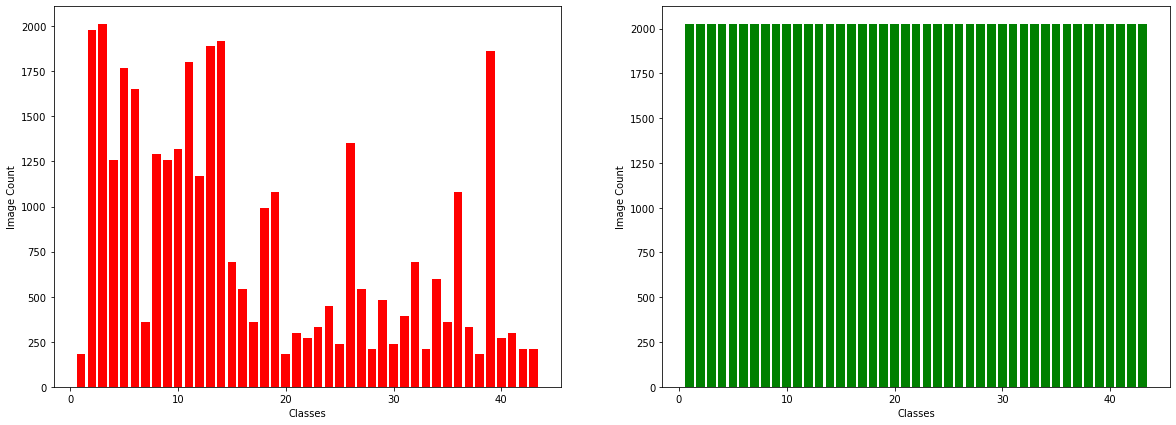

In [11]:
plt.figure(figsize = (20,7))
plt.subplot(121)
plt.bar([i+1 for i in range(43)],np.bincount(y_train_old),color='r')
plt.xlabel("Classes")
plt.ylabel("Image Count")

plt.subplot(122)
plt.bar([i+1 for i in range(43)],np.bincount(y_train),color='g')
plt.xlabel("Classes")
plt.ylabel("Image Count")

In [12]:
x_train, y_train = shuffle(x_train, y_train)
x_val, y_val = shuffle(x_val,y_val)
x_test, y_test = shuffle(x_test,y_test)

data_dict = {'x_train': x_train, 'y_train': y_train,
            'x_val': x_val, 'y_val': y_val,
            'x_test': x_test, 'y_test': y_test,
            'labels': label_list}

In [13]:
def preprocess_data(data_dict):
    '''
    Given a dataset of
    training, test and
    validation images, performs
    preprocessing based
    on the parameters 
    provided.
    
    Parameters
    ----------
    data_dict : Dictionary
        Dataset of images
        to be preprocessed.
        
        
    PreProcessing applied:-
    ---------------------
    1. Shuffle the dataset.
        
    2. Apply local histogram
    equalization to spreads out
    the most frequent intensity
    values in an image.
        
    3. Normalize each value
    in dataset by the mean.
        
    4. Normalize data by dividing
    with the standard deviation.
    
    '''
    assert(isinstance(data_dict,dict))
    
    # Applying Shuffling
    np.random.seed(0)
    np.random.shuffle(data_dict['x_train'])
    np.random.seed(0)
    np.random.shuffle(data_dict['y_train'])
    np.random.seed(0)
    np.random.shuffle(data_dict['x_val'])
    np.random.seed(0)
    np.random.shuffle(data_dict['y_val'])
    np.random.seed(0)
    np.random.shuffle(data_dict['x_test'])
    np.random.seed(0)
    np.random.shuffle(data_dict['y_test'])

    # Applying /255.0 Normalization
    data_dict['x_train'] = data_dict['x_train'].astype(np.float32) / 255.0
    data_dict['x_val'] /= 255.0
    data_dict['x_test'] /= 255.0

    mean_image = np.mean(data_dict['x_train'], axis=0)  # numpy.ndarray (3, 32, 32)
    std = np.std(data_dict['x_train'], axis=0)  # numpy.ndarray (3, 32, 32)

    # Applying Mean Normalization
    data_dict['x_train'] -= mean_image
    data_dict['x_val'] -= mean_image
    data_dict['x_test'] -= mean_image

    # Applying STD Normalization
    data_dict['x_train'] /= std
    data_dict['x_val'] /= std
    data_dict['x_test'] /= std

    # Returning preprocessed data
    return data_dict

In [14]:
processed_data = preprocess_data(data_dict)

In [15]:
with open(os.path.join(DATA_PATH, 'processed_data.pickle'),'wb') as f:
    pickle.dump(processed_data,f)
    f.close